## Import Relevant packages

In [1]:
import pandas as pd
import numpy as np
import os

# For Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

# For Data Preparation
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.tree import plot_tree
import re

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# For Evaluation of Results
from sklearn.metrics import f1_score
from sklearn import metrics

# For Product
from IPython.display import HTML
from termcolor import colored
from pyfiglet import Figlet

pd.options.mode.chained_assignment = None

## Importing of Dataset

Our dataset has 5 columns:

'v1': States whether the message is 'ham' (non-spam) or 'spam'

'v2': The content of the message

'Unnamed: 2': Contains some text, most of the cells are empty

'Unnamed: 3': Contains some text, most of the cells are empty

'Unnamed: 4': Contains some text, most of the cells are empty


Let's explore the dataset and do some preliminary cleaning.

In [2]:
df = pd.read_csv('spam.csv', encoding='iso-8859-1')
df.shape

(5572, 5)

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


At first glance, it's unclear what the 'Unnamed' columns are for. Let's take a look.

In [5]:
unnamed = df[df['Unnamed: 2'].isnull()==False]
unnamed.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


After looking at the original file, we found that these columns are actually a continuation of the main message. They were separated into different columns by the commas within the message itself. We will combine the last four columns together and rename them for better readability.

In [6]:
df['full_message'] = df['v2'].fillna('') + ' ' + df['Unnamed: 2'].fillna('')+ ' ' + df['Unnamed: 3'].fillna('')+ ' ' + df['Unnamed: 4'].fillna('')

df.rename(columns={'v1':'Category', 'full_message':'Message'}, inplace = True)
df = df.drop(['v2', 'Unnamed: 2', 'Unnamed: 3','Unnamed: 4'], axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape 

(5572, 2)

In [8]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


It seems that not all of the messages are unique, which means that there are some duplicates. We will explore these later.

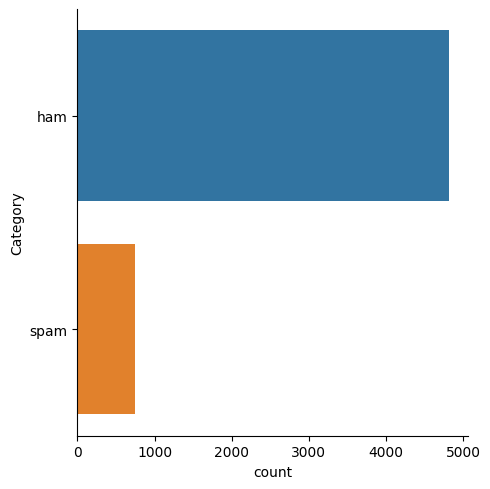

In [9]:
sns.catplot(y='Category', data=df, kind='count')

In [10]:
countY, countX = df.Category.value_counts()
print("The ratio of non-spam to spam is %.2f: 1" % (countY/countX))

The ratio of non-spam to spam is 6.46: 1


As you can see, the data is quite imbalanced between non-spam and spam messages, which may affect the accuracy of any machine learning models we will use to predict the type of message. We will do some more data cleaning and then do exploratory data analysis.

## Data Cleaning

#### Changing of 'ham' and 'spam' to 0 and 1 respectively

In [11]:
df.loc[df.Category == 'ham', 'Category'] = 0
df.loc[df.Category == 'spam', 'Category'] = 1
print(df.Category.value_counts())

0    4825
1     747
Name: Category, dtype: int64


#### Removal of duplicates in SMS Messages

In [12]:
df.duplicated(subset=['Message']).value_counts()

False    5169
True      403
dtype: int64

As seen, there are 403 duplicates in the dataset and have to be removed in order to prevent skewing the data.


In [13]:
df = df.drop_duplicates(subset=['Message'], keep = 'last')
df.reset_index(drop=True, inplace=True)

print(df.shape)
print(df["Category"].value_counts())

(5169, 2)
0    4516
1     653
Name: Category, dtype: int64


In [14]:
df.describe()

,Category,Message
count,5169,5169
unique,2,5169
top,0,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


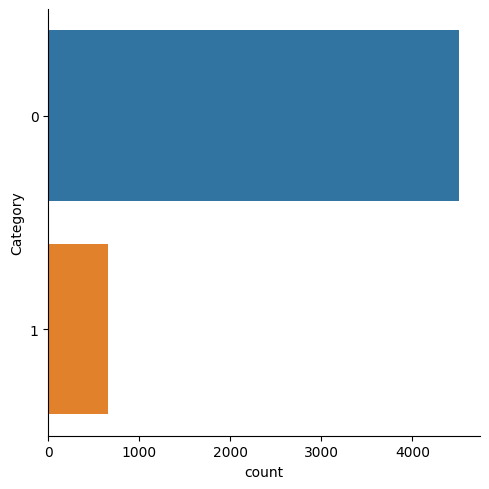

In [15]:
sns.catplot(y='Category', data=df, kind='count') 

In [16]:
countY, countX = df.Category.value_counts()
print("The ratio of non-spam to spam is %.2f: 1" % (countY/countX))

The ratio of non-spam to spam is 6.92: 1


The ratio of non-spam to spam is even higher now. This means that a majority of the duplicated messages that were removed were spam. Makes sense, since the same spam message is often sent to many people at once.

## Data Preparation

Generating Stop Words

In [17]:
stopwords = list(ENGLISH_STOP_WORDS) + list(STOPWORDS) + ['u']
print(stopwords)

['perhaps', 'latter', 'made', 'cant', 'himself', 'have', 'should', 'so', 'beside', 'has', 'her', 'whither', 'them', 'themselves', 'meanwhile', 'sometimes', 'other', 'those', 'were', 'only', 'as', 'here', 'herein', 'three', 'still', 'thru', 'whose', 'beyond', 'please', 'through', 'others', 'besides', 'nobody', 'hundred', 'and', 'twenty', 'eg', 'seem', 'now', 'eleven', 'sixty', 'ever', 'bill', 'back', 'towards', 'whenever', 'namely', 'neither', 'call', 'if', 'their', 'each', 'this', 'un', 'by', 'but', 'everything', 'whole', 'becoming', 'out', 'us', 'wherever', 'these', 'ourselves', 'may', 'become', 'mine', 'even', 'would', 'serious', 'go', 'is', 'most', 'thereby', 'forty', 'though', 'thick', 'empty', 'there', 'whereupon', 'anywhere', 'in', 'yourself', 'eight', 'latterly', 'or', 'than', 'however', 'thence', 'already', 'after', 'something', 'up', 'fill', 'due', 'although', 'nine', 'one', 'own', 'during', 'a', 'fifteen', 'within', 'whereas', 'thin', 'ours', 'found', 'am', 'without', 'toward


#### Phone Number Detection

Spam messages often contain a link or phone number which lures victims into giving away their private information. Let's see if this is reflected in our dataset.

Looking through the data, there are many instances when phone numbers were present in the message and the message was classified as spam.

In [18]:
pattern = r'\d{6,}'

df['Contain_HP'] = df['Message'].apply(lambda x: bool(re.search(pattern, x)))

df.head(10)

,Category,Message,Contain_HP
0,0,"Go until jurong point, crazy.. Available only ...",False
1,0,Ok lar... Joking wif u oni...,False
2,0,U dun say so early hor... U c already then say...,False
3,0,"Nah I don't think he goes to usf, he lives aro...",False
4,1,FreeMsg Hey there darling it's been 3 week's n...,False
5,0,Even my brother is not like to speak with me. ...,False
6,0,I'm gonna be home soon and i don't want to tal...,False
7,0,I've been searching for the right words to tha...,False
8,0,I HAVE A DATE ON SUNDAY WITH WILL!!,False
9,1,"XXXMobileMovieClub: To use your credit, click ...",False


In [19]:
df['Contain_HP'].value_counts()

False    4801
True      368
Name: Contain_HP, dtype: int64

# Machine Learning

### Removing Stopwords
Removing Stopwords from all messages by creating a DataFrame containing all messages

In [20]:
df_x = df[['Message', 'Contain_HP']]
df_y = df.Category

In [21]:
def remove_stopwords(message):
    stop_words = set(stopwords)
    words = message.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [22]:
for x in df_x.itertuples():
    df_x.at[x.Index, "Message"] = remove_stopwords(x.Message)

### Vectorizing strings to matrix

TfidVectorizer converts strings into a matrix of numbers that measure how relevant certain words are to a particular type of message, usually based on how often they appear. These values make it easier for machine learning algorithms to analyse the data and make predictions.

Here, we will split the dataset into test and train data, and begin running prediction models.

In [23]:
cv = TfidfVectorizer(min_df = 1, stop_words='english')

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state = 42)
test_length = len(x_test)

In [25]:
x_traincv = cv.fit_transform(x_train.Message)
x_testcv = cv.transform(x_test.Message)

In [26]:
result = pd.DataFrame()
result['Model'] = None
result['Accuracy'] = None
result['F1_score'] = None

## Training with Naive Bayes

This is a classification algorithm based on weights assigned to individual words.

In [27]:
mnb_nb = MultinomialNB()
a_nb = x_traincv.toarray()
y_train = y_train.astype(int)
y_test = y_test.astype(int)
mnb_nb.fit(x_traincv, y_train)

MultinomialNB()

In [28]:
y_pred_nb = mnb_nb.predict(x_testcv)
actual_nb = np.array(y_test)

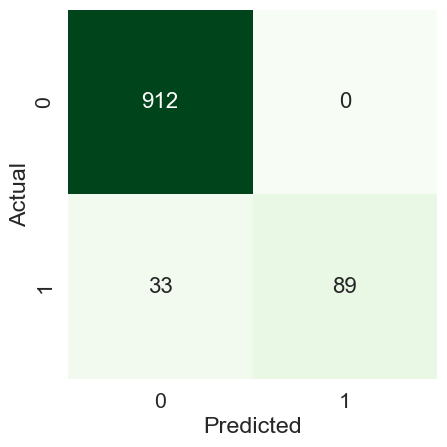

In [29]:
cm = confusion_matrix(actual_nb, y_pred_nb)
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 16}, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [30]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_nb = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_nb)
print("F1 Score: ", f1_score(actual_nb, y_pred_nb))

True Positive Rate (TPR):  0.7295081967213115
True Negative Rate (TNR):  1.0
False Positive Rate (FPR):  0.0
False Negative Rate (FNR):  0.27049180327868855
Accuracy:  0.9680851063829787
F1 Score:  0.8436018957345972


In [31]:
result = pd.concat([result,pd.DataFrame({"Model": "Naive Bayes","Accuracy":acc_nb,'F1_score':f1_score(actual_nb, y_pred_nb)}, index=[0])]).reset_index(drop=True)

The Naive Bayes model is quite accurate as it has an accuracy score of 0.968 and a 1.0 true negative rate. However, the false negative rate is quite high which may be due to the imbalance of the dataset that was mentioned earlier. Since a majority of the messages were non-spam messages, many of the actual spam messages were predicted to be non-spam. Let's try out a few more models.

## Training with SVC

Support Vector Classification (SVC) is a prediction algorithm based on the features of the messages.

In [32]:
classifier_svc = SVC(random_state = 0)
classifier_svc.fit(x_traincv, y_train) 

SVC(random_state=0)

In [33]:
print(classifier_svc.score(x_testcv,y_test))

0.97678916827853


In [34]:
y_pred_svc = classifier_svc.predict(x_testcv)

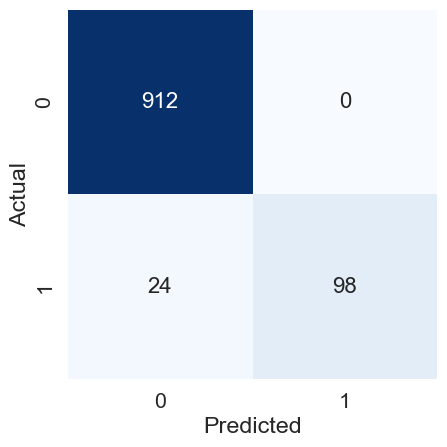

In [35]:
cm = confusion_matrix(y_test, y_pred_svc)

sns.set(font_scale=1.4) 

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, annot_kws={"size": 16}, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

#### Calculate Accuracies

In [36]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_svc = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_svc)
print("F1 Score: ", f1_score(y_test, y_pred_svc))

True Positive Rate (TPR):  0.8032786885245902
True Negative Rate (TNR):  1.0
False Positive Rate (FPR):  0.0
False Negative Rate (FNR):  0.19672131147540983
Accuracy:  0.97678916827853
F1 Score:  0.8909090909090909


In [37]:
result = pd.concat([result,pd.DataFrame({"Model": "SVC","Accuracy":acc_svc,'F1_score':f1_score(y_test, y_pred_svc)}, index=[0])]).reset_index(drop=True)

The SVC model is better than the Naive Bayes model as the false negative rate is lower and the true positive rate is higher. The accuracy score and the F1 score are also better than Naive Bayes.

## Training with Random Forest Classifier

The Random Forest Classifier is a classification algorithm based on multiple decision trees.

In [38]:
classifier_rfc = RandomForestClassifier()
classifier_rfc.fit(x_traincv, y_train)
y_pred_rfc = classifier_rfc.predict(x_testcv)

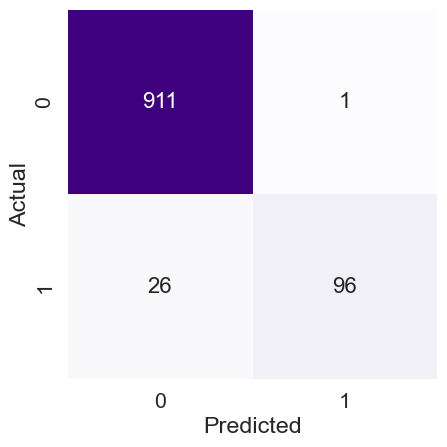

In [39]:
cm = confusion_matrix(y_test, y_pred_rfc)
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False, annot_kws={"size": 16}, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

#### Calculate Accuracies

In [40]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_rfc = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_rfc)
print("F1 Score: ", f1_score(y_test, y_pred_rfc))

True Positive Rate (TPR):  0.7868852459016393
True Negative Rate (TNR):  0.9989035087719298
False Positive Rate (FPR):  0.0010964912280701754
False Negative Rate (FNR):  0.21311475409836064
Accuracy:  0.9738878143133463
F1 Score:  0.8767123287671234


In [41]:
result = pd.concat([result,pd.DataFrame({"Model": "Random Forest Classifier","Accuracy":acc_rfc,'F1_score':f1_score(y_test, y_pred_rfc)}, index=[0])]).reset_index(drop=True)

Unlike the previous 2 models, the Random Forest Classifier has 1 false positive. Its false negative rate is lower than Naive Bayes but higher than SVC. This means that SVC is still the model with the highest accuracy.

## Training with Logistic Regression

Logistic Regression makes predictions based on both 'Messages' and 'Contains_HP'.

In [42]:
X_train_combined = pd.concat([pd.DataFrame(x_traincv.toarray()), x_train['Contain_HP'].reset_index(drop=True)], axis=1)
X_test_combined = pd.concat([pd.DataFrame(x_testcv.toarray()), x_test['Contain_HP'].reset_index(drop=True)], axis=1)

lr = LogisticRegression()
X_train_combined.columns = X_train_combined.columns.astype(str)
X_test_combined.columns = X_test_combined.columns.astype(str)

lr.fit(X_train_combined, y_train)

y_pred_lr = lr.predict(X_test_combined)


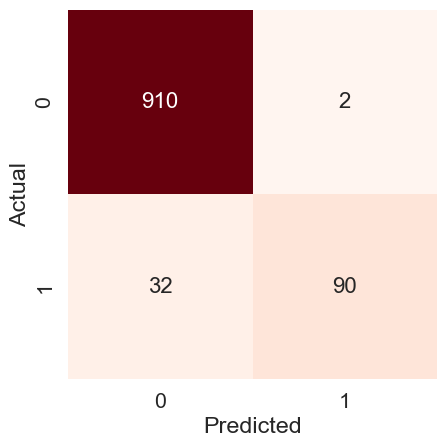

In [43]:
cm = confusion_matrix(y_test, y_pred_lr)
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', cbar=False, annot_kws={"size": 16}, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

#### Calculate Accuracies

In [44]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_lr = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_lr)
print("F1 Score: ", f1_score(y_test, y_pred_lr))

True Positive Rate (TPR):  0.7377049180327869
True Negative Rate (TNR):  0.9978070175438597
False Positive Rate (FPR):  0.0021929824561403508
False Negative Rate (FNR):  0.26229508196721313
Accuracy:  0.9671179883945842
F1 Score:  0.8411214953271028


In [45]:
result = pd.concat([result,pd.DataFrame({"Model": "Logistic Regression","Accuracy":acc_lr,'F1_score':f1_score(y_test, y_pred_lr)}, index=[0])]).reset_index(drop=True)

Logistic regression turns out to be the worst of all of the 4 models we have tried. It has the highest false positive rate and false negative rate.

## Model Ensemble

We will try to combine all the 4 models we have used - Naive Bayes, SVC, Random Forest Classifier, and Logistic Regression - into one model which should be more accurate than the individual models. The idea here is similar to a voting system - if a majority of the models predict a message to be spam, then the final prediction will be that it is a spam message. This would eliminate many of the false negatives that were present in the previous models.

After playing with the parameters, we found that having just 1 model to determine whether a message is spam provided the highest accuracy score.

In [46]:
ensemble = []
x_testlist = x_test.to_numpy()
for i in range(len(y_pred_lr)):
    if y_pred_lr[i] + y_pred_nb[i] + y_pred_rfc[i] + y_pred_svc[i] > 0:
        ensemble.append([1])
    else:
        ensemble.append([0])
ensemble_arr = np.array(ensemble)

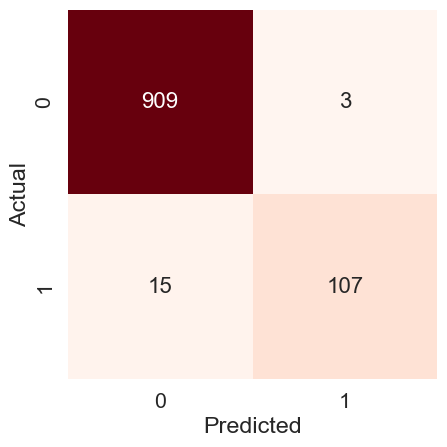

In [47]:
cm = confusion_matrix(y_test, ensemble_arr)
sns.set(font_scale=1.4) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', cbar=False, annot_kws={"size": 16}, square=True)

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

#### Calculate Accuracies

In [48]:
true_pos = cm[1][1] / (cm[1][1] + cm[1][0])
true_neg = cm[0][0] / (cm[0][0] + cm[0][1])
false_pos = cm[0][1] / (cm[0][1] + cm[0][0])
false_neg = cm[1][0] / (cm[1][0] + cm[1][1])
acc_me = (cm[0][0] + cm[1][1]) / (cm[1][0] + cm[0][1] + cm[0][0] + cm[1][1])
print("True Positive Rate (TPR): ", true_pos)
print("True Negative Rate (TNR): ", true_neg)
print("False Positive Rate (FPR): ", false_pos)
print("False Negative Rate (FNR): ", false_neg)
print("Accuracy: ", acc_me)
print("F1 Score: ", f1_score(y_test, ensemble_arr))

True Positive Rate (TPR):  0.8770491803278688
True Negative Rate (TNR):  0.9967105263157895
False Positive Rate (FPR):  0.003289473684210526
False Negative Rate (FNR):  0.12295081967213115
Accuracy:  0.9825918762088974
F1 Score:  0.9224137931034483


In [49]:
result = pd.concat([result,pd.DataFrame({"Model":"Model Ensemble","Accuracy":acc_me,'F1_score':f1_score(y_test, ensemble_arr)}, index=[0])]).reset_index(drop=True)

As expected, the Model Ensemble is even more accurate than all the 4 models. Its false negative rate is much lower than SVC, and both the accuracy score and F1 score are the highest.